# Mask R-CNN Demo

A quick intro to using the pre-trained model to detect and segment objects.

In [1]:
import sys
!{sys.executable} -m pip install tensorflow==1.13.1
!{sys.executable} -m pip install keras==2.0.8
!{sys.executable} -m pip install opencv-contrib-python==3.4.2.16 --user

In [1]:
import os
import sys
import random
import math
import numpy as np
import skimage.io
import cv2
import matplotlib
import matplotlib.pyplot as plt

# Root directory of the project
ROOT_DIR = os.path.abspath("../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
# Import COCO config
sys.path.append(os.path.join(ROOT_DIR, "samples/coco/"))  # To find local version
import coco

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Directory of images to run detection on
IMAGE_DIR = os.path.join(ROOT_DIR, "images")

Using TensorFlow backend.


## Configurations

We'll be using a model trained on the MS-COCO dataset. The configurations of this model are in the ```CocoConfig``` class in ```coco.py```.

For inferencing, modify the configurations a bit to fit the task. To do so, sub-class the ```CocoConfig``` class and override the attributes you need to change.

In [2]:
class InferenceConfig(coco.CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    NUM_CLASSES = 1 + 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

## Create Model and Load Trained Weights

In [3]:
# Create model object in inference mode.
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

# Load weights trained on MS-COCO
model.load_weights(COCO_MODEL_PATH, by_name=True)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
Use tf.cast instead.


## Class Names

The model classifies objects and returns class IDs, which are integer value that identify each class. Some datasets assign integer values to their classes and some don't. For example, in the MS-COCO dataset, the 'person' class is 1 and 'teddy bear' is 88. The IDs are often sequential, but not always. The COCO dataset, for example, has classes associated with class IDs 70 and 72, but not 71.

To improve consistency, and to support training on data from multiple sources at the same time, our ```Dataset``` class assigns it's own sequential integer IDs to each class. For example, if you load the COCO dataset using our ```Dataset``` class, the 'person' class would get class ID = 1 (just like COCO) and the 'teddy bear' class is 78 (different from COCO). Keep that in mind when mapping class IDs to class names.

To get the list of class names, you'd load the dataset and then use the ```class_names``` property like this.
```
# Load COCO dataset
dataset = coco.CocoDataset()
dataset.load_coco(COCO_DIR, "train")
dataset.prepare()

# Print class names
print(dataset.class_names)
```

We don't want to require you to download the COCO dataset just to run this demo, so we're including the list of class names below. The index of the class name in the list represent its ID (first class is 0, second is 1, third is 2, ...etc.)

In [4]:
# COCO Class names
# Index of the class in the list is its ID. For example, to get ID of
# the teddy bear class, use: class_names.index('teddy bear')
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']
#custom class
class_names = ['BG', 'person']

## Function implementation

In [5]:
def dilation(image, mask, iteration = 1):
    img = cv2.dilate(image, mask)
    if iteration <= 1:
        return img
    return dilation(img, mask, iteration-1)

In [6]:
# make background black
def apply_blur_mask(image, mask, dilateIteration = 1):
    #dilation to make sure not to cut person
    kernel = np.ones((5,5),np.uint8) 
    mask = dilation(mask.astype(np.uint8)*255, kernel, dilateIteration)
    blur = cv2.blur(image, (7,7))
    print("dilate mask complete", dilateIteration)
    image[:, :, 0] = np.where(
        mask == 0,
        blur[:, :, 0],
        image[:, :, 0]
    )
    image[:, :, 1] = np.where(
        mask == 0,
        blur[:, :, 1],
        image[:, :, 1]
    )
    image[:, :, 2] = np.where(
        mask == 0,
        blur[:, :, 2],
        image[:, :, 2]
    )
    return image

In [7]:
# make background black
def apply_black_mask(image, mask, dilateIteration = 1):
    #dilation to make sure not to cut person
    kernel = np.ones((5,5),np.uint8) 
    mask = dilation(mask.astype(np.uint8)*255, kernel, dilateIteration)
    print("dilate mask complete", dilateIteration)
    image[:, :, 0] = np.where(
        mask == 0,
        0,
        image[:, :, 0]
    )
    image[:, :, 1] = np.where(
        mask == 0,
        0,
        image[:, :, 1]
    )
    image[:, :, 2] = np.where(
        mask == 0,
        0,
        image[:, :, 2]
    )
    return image

In [27]:
# This function is used to change the colorful background information to grayscale.
# image[:,:,0] is the Blue channel,image[:,:,1] is the Green channel, image[:,:,2] is the Red channel
# mask == 0 means that this pixel is not belong to the object.
# np.where function means that if the pixel belong to background, change it to gray_image.
# Since the gray_image is 2D, for each pixel in background, we should set 3 channels to the same value to keep the grayscale.
def apply_mask(image, mask):
    image[:, :, 0] = np.where(
        mask == 0,
        gray_image[:, :],
        image[:, :, 0]
    )
    image[:, :, 1] = np.where(
        mask == 0,
        gray_image[:, :],
        image[:, :, 1]
    )
    image[:, :, 2] = np.where(
        mask == 0,
        gray_image[:, :],
        image[:, :, 2]
    )
    return image

In [13]:
# This function is used to show the object detection result in original image.
def display_instances(image, boxes, masks, ids, names, scores, dilation = 0):
    # max_area will save the largest object for all the detection results
    max_area = 0
    # n_instances saves the amount of all objects
    n_instances = boxes.shape[0]
    if not n_instances:
        print('NO INSTANCES TO DISPLAY')
    else:
        assert boxes.shape[0] == masks.shape[-1] == ids.shape[0]

    for i in range(n_instances):
        if not np.any(boxes[i]):
            continue
        # compute the square of each object
        y1, x1, y2, x2 = boxes[i]
        square = (y2 - y1) * (x2 - x1)
        # use label to select person object from all the 80 classes in COCO dataset
        label = names[ids[i]]
        if label == 'person':
            # save the largest object in the image as main character
            # other people will be regarded as background
            if square > max_area:
                max_area = square
                mask = masks[:, :, i]
            else:
                continue
        else:
            continue
    # apply mask for the image
    # by mistake you put apply_mask inside for loop or you can write continue in if also
    print("generate mask complete")
    image = apply_blur_mask(image, mask, dilation)    
    return image

## Run Object Detection

In [14]:
# Use OpenCV to read and show the original image
image = cv2.imread('girl.png')
cv2.imshow('original_image', image)

print("Read original image successfully! The original image shape is:")
print(image.shape)
print("Press ESC to exit or press s to save and exit.")

# Wait for keys to exit or save
cv2.waitKey(0)       
cv2.imwrite('original_image.jpg', image)
cv2.destroyAllWindows()

Read original image successfully! The original image shape is:
(800, 533, 3)
Press ESC to exit or press s to save and exit.


In [15]:
# Use cvtColor to accomplish image transformation from RGB image to gray image
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
cv2.imshow('gray_image', gray_image)

print("Change gray image successfully! The gray image shape is:")
print(gray_image.shape)
print("Press ESC to exit or press s to save and exit.")

# Wait for keys to exit or save
cv2.waitKey(0)       
cv2.imwrite('gray_image.jpg', image)
cv2.destroyAllWindows()

Change gray image successfully! The gray image shape is:
(1706, 960)
Press ESC to exit or press s to save and exit.


In [15]:
results = model.detect([image], verbose=0)
r = results[0]
frame = display_instances(
    image, r['rois'], r['masks'], r['class_ids'], class_names, r['scores'],0
)
cv2.imshow('result', frame)

# Wait for keys to exit or save
cv2.waitKey(0)     
cv2.imwrite('girl_blur.jpg', image)
cv2.destroyAllWindows()

generate mask complete
dilate mask complete 0


Processing 1 images
image                    shape: (425, 640, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


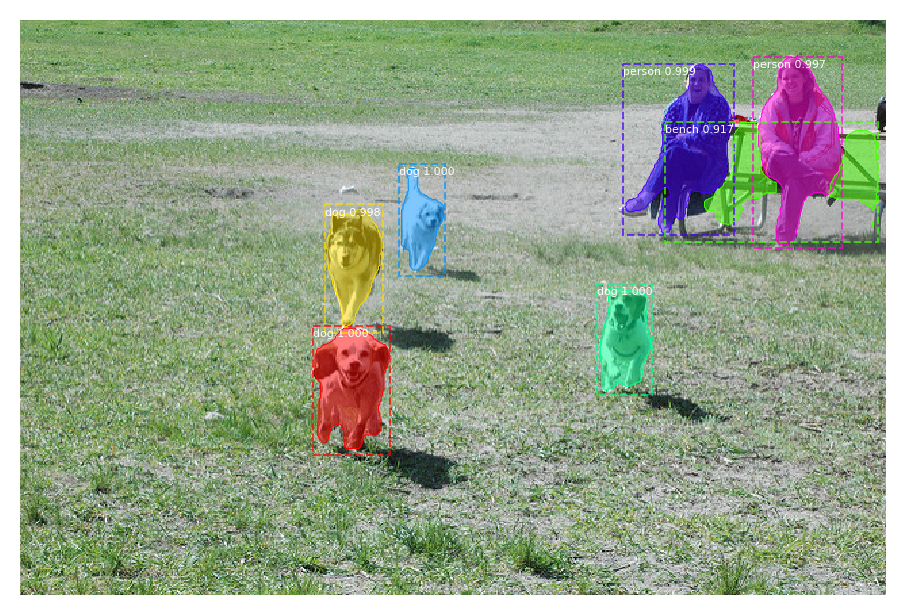

In [6]:
######################origon code##########################
# Load a random image from the images folder
file_names = next(os.walk(IMAGE_DIR))[2]
image = skimage.io.imread(os.path.join(IMAGE_DIR, random.choice(file_names)))



# Run detection
results = model.detect([image], verbose=1)

# Visualize results
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'])